## Imports

In [1]:
# Data manipulation
import time
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# KERAS
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Fine-Tune your Neural Network and Save it

🎯 **Goals of this challenge**

1. ⚙️ **Fine-tune the optimizer** of a Neural Network
2. 💾 **Save**/**Load** a trained Neural Network

👩🏻‍🏫 Now that you have solid foundations about what Neural Networks are, how to design their architecture, and how to prevent them from overfitting, let's take a closer look at the `.compile(loss = ?, metrics = ?, activation = ?)` part.

## (0) The Boston Housing Dataset

📚 `Tensorflow.Keras` has several built-in datasets that you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

🏠 Out of those, we are going to use the **Boston Housing Dataset**.

Our mission is to **predict the values of the houses in USD (thousands)**, and we will measure the performance of our models using the _Mean Absolute Error (MAE)_ metric.

### (0.1) Loading the Dataset

In [2]:
# Loading the dataset:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

57026/57026 [==============================] - 0s 7us/step


In [3]:
# Shape of the dataset: 
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((404, 13), (404,)), ((102, 13), (102,)))

### (0.2) Quick Glance at the Target

<AxesSubplot:ylabel='Count'>

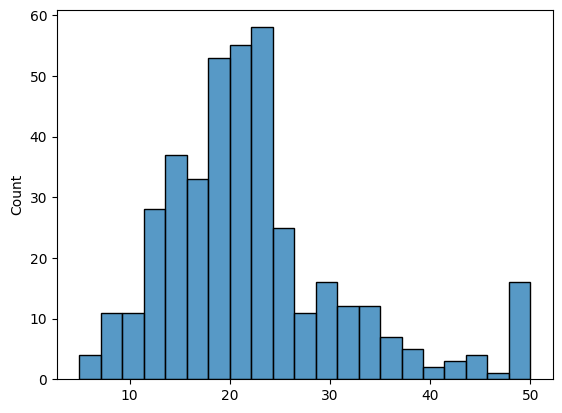

In [4]:
# Distribution of the houses' prices in the training set
sns.histplot(y_train)

In [5]:
# Null values and types of each feature:
pd.DataFrame(X_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       404 non-null    float64
 1   1       404 non-null    float64
 2   2       404 non-null    float64
 3   3       404 non-null    float64
 4   4       404 non-null    float64
 5   5       404 non-null    float64
 6   6       404 non-null    float64
 7   7       404 non-null    float64
 8   8       404 non-null    float64
 9   9       404 non-null    float64
 10  10      404 non-null    float64
 11  11      404 non-null    float64
 12  12      404 non-null    float64
dtypes: float64(13)
memory usage: 41.2 KB


In [6]:
# Statistics about the numerical columns
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


### (0.3) Minimal Data Preprocessing

👉 Here, we don't have any duplicates or missing values. Let's do the bare minimum of data preprocessing, i.e. ***scaling**, and move on quickly to the modeling phase.

#### ❓Scaling your Features

Standardize `X_train` and `X_test`.

In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### (0.4) Baseline Model

🧑🏻‍🏫 In a regression task, the baseline model **always predicts the average value of `y_train`**

<details>
    <summary>Really?</summary>
    
- 🐒  Yes, in most cases!
- ❗️  Be aware that this is not the only possible way of building a baseline model
- 💹  In Time Series, the baseline model predicts the **last seen value**

#### ❓Question: what would be the performance of the baseline model here?

Before running any Machine Learning algorithm or advanced Deep Learning Neural Networks, it would be great to establish a benchmark score that you are supposed to beat. Otherwise, what is the point of running a fancy algorithm if you cannot beat this benchmark score on the testing set (other than showing off)?

Compute the Mean Absolute Error on the testing set using a "dumb" prediction of the mean value of `y_train`, computed on the training set.

In [95]:
from sklearn.metrics import mean_absolute_error as mae

y_pred = np.repeat(y_train.mean(), 404)
mean_absolute_error_test_baseline = mae(y_train, y_pred)
mean_absolute_error_test_baseline

6.647632585040682

## (1) The Neural Network

### ❓Initializing a Neural Network with a Specific Architecture

Write a function called `initialize_model` that generates a Neural Network with 3 layers:
- Input layer: **10 neurons**, `relu` activation function, and the appropriate input dimension
- Hidden layer: **7 neurons** and the `relu` activation function
- Predictive layer: an appropriate layer corresponding to the problem we are trying to solve

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()

    model.add(layers.Dense(10, activation='relu', input_dim=13))
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    
    return model

#### ❓Number of Parameters

How many parameters do we have in this model? 
1. Compute this number yourself
2. Double-check your answer with `model.summary()`

We already covered the question about the number of parameters in a fully connected/dense network during **Deep Learning > 01. Fundamentals of Deep Learning** but it is always good to make sure you master the foundations of a new discipline 😉

In [16]:
model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                140       
                                                                 
 dense_4 (Dense)             (None, 7)                 77        
                                                                 
 dense_5 (Dense)             (None, 1)                 8         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


##### 💡Answer

<details>
    <summary>Click here</summary>

- Each house has `X_train.shape[-1]` = 13 features
- Remember that a neuron is a linear regression combined with an activation function, so we will have 13 weights and 1 bias

1. First layer: **10 neurons** $\times$ (13 weights + 1 bias ) = 140 params
2. Second layer: **7 neurons** $\times$ (10 weights + 1 bias ) = 77 params
3. Third layer: **1 neuron** $\times$ (7 weights + 1 bias) = 8 params
</details>

## (2) The Optimizer

### ❓Compiling Method

Write a function that:
1. takes _both_ a **model** and an **optimizer** as arguments
2. **compiles** the model
3. returns the compiled model

Please select wisely:
- the **Loss Function** to be optimized
- the **metrics** on which the model should be evaluated

In [96]:
def compile_model(model, optimizer_name):
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss='mse', # We've already mentioned this loss function in Logistic Regression
                  optimizer=optimizer_name, # Optimizer in Deep Learning = solver in Machine Learning | Adam = our best friend
                  metrics=['mae'])# 
    return model

### ❓Evaluating the Model

- Initialize the model and compile it with the `adam` optimizer
- Fit it on the training data
- Evaluate your model on the testing data

Don't forget to use an Early Stopping criterion to avoid overfitting!

<details>
    <summary>Notes</summary>

As we saw in the **"How to prevent overfitting"** challenge,  you could also use L2 penalties and Dropout Layers to prevent overfitting but:
- Early Stopping is the easiest and quickest code to implement, you just declare `es = EarlyStopping()` and call it back in the `.fit()` step
- The main goal of this challenge is to understand the **impact of the optimizer**, so stay focused 😉
</details>

In [ ]:
m = compile_model(model, 'adam')

es = EarlyStopping(patience=20, restore_best_weights=True)

# Fit the model on the train data
history = m.fit(
    X_train_scaled,
    y_train,
    epochs = 500,
    batch_size = 16, 
    verbose = 1,
    callbacks = [es],
    validation_split = 0.2,
    shuffle = True# This will call the Early Stopping Criterion for each epoch
)

In [98]:
error_neural = m.evaluate(scaler.transform(X_test), y_test)
res = error_neural[1]

4/4 [==============================] - 0s 770us/step - loss: 18.5941 - mae: 2.6473


### Neural Network vs. Baseline

Compare the MAE on the testing set between this Neural Network and the baseline model.

In [99]:
y_pred = m.predict(scaler.transform(X_test))


4/4 [==============================] - 0s 613us/step


3.000421475429161

In [100]:
mae_test_baseline = mean_absolute_error_test_baseline
mae_test_neuralnet = res

print(f"The MAE on the test is {mae_test_neuralnet:.4f} for the Neural Network vs. {mae_test_baseline:.4f} for the baseline")

The MAE on the test is 2.6473 for the Neural Network vs. 6.6476 for the baseline


### (2.1) Which Optimizer is the Best? 

#### ❓Trying Different Optimizers

Re-run the same model on the same data using different optimizers (in a `for` loop). 

For each optimizer:
- 📉 Plot the history of the loss (MSE) and the metric (MAE)
    - 🎁 We coded two functions: `plot_loss_mae` and `plot_loss_mse`. Which one should you use? Feel free to use it.
- ✍️ Report the corresponding Mean Absolute Error
- ⏳ Compute the time your Neural Net needed to fit the training set

📚 [`tensorflow.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [72]:
def plot_loss_mae(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=200)
    ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    plt.show() 

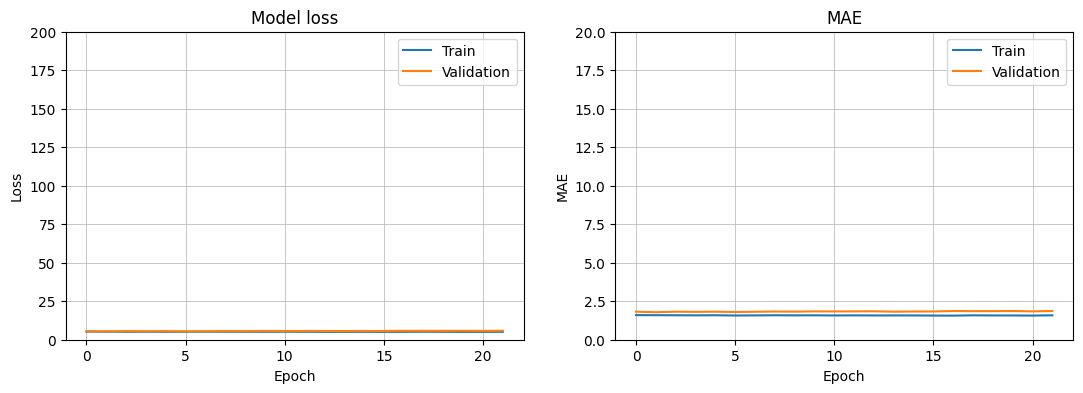

In [104]:
plot_loss_mae(history)

In [79]:
def plot_loss_mse(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mse'])
    ax2.plot(history.history['val_mse'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=20)
    ax2.set_ylim(ymin=0, ymax=200)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    plt.show()

Epoch 1/500
21/21 [==============================] - 0s 3ms/step - loss: 5.1265 - mae: 1.5696 - val_loss: 5.7099 - val_mae: 1.8499
Epoch 2/500
21/21 [==============================] - 0s 747us/step - loss: 5.0664 - mae: 1.5673 - val_loss: 5.7041 - val_mae: 1.8459
Epoch 3/500
21/21 [==============================] - 0s 832us/step - loss: 5.0500 - mae: 1.5580 - val_loss: 5.7090 - val_mae: 1.8461
Epoch 4/500
21/21 [==============================] - 0s 691us/step - loss: 5.0495 - mae: 1.5604 - val_loss: 5.7131 - val_mae: 1.8447
Epoch 5/500
21/21 [==============================] - 0s 680us/step - loss: 5.0443 - mae: 1.5565 - val_loss: 5.7260 - val_mae: 1.8494
Epoch 6/500
21/21 [==============================] - 0s 677us/step - loss: 5.0429 - mae: 1.5555 - val_loss: 5.7326 - val_mae: 1.8516
Epoch 7/500
21/21 [==============================] - 0s 651us/step - loss: 5.0408 - mae: 1.5567 - val_loss: 5.7303 - val_mae: 1.8511
Epoch 8/500
21/21 [==============================] - 0s 686us/step - lo

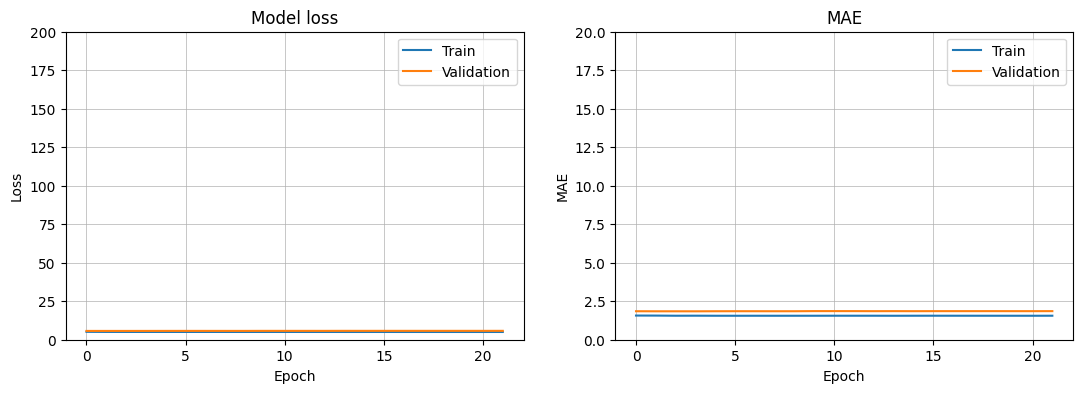

Epoch 1/500
21/21 [==============================] - 0s 3ms/step - loss: 5.3398 - mae: 1.6133 - val_loss: 5.8080 - val_mae: 1.8635
Epoch 2/500
21/21 [==============================] - 0s 796us/step - loss: 5.1986 - mae: 1.5901 - val_loss: 5.8974 - val_mae: 1.9025
Epoch 3/500
21/21 [==============================] - 0s 730us/step - loss: 5.2038 - mae: 1.5826 - val_loss: 5.7131 - val_mae: 1.8510
Epoch 4/500
21/21 [==============================] - 0s 704us/step - loss: 5.2086 - mae: 1.5811 - val_loss: 5.7968 - val_mae: 1.8600
Epoch 5/500
21/21 [==============================] - 0s 685us/step - loss: 5.2037 - mae: 1.5828 - val_loss: 5.8517 - val_mae: 1.8904
Epoch 6/500
21/21 [==============================] - 0s 642us/step - loss: 5.2488 - mae: 1.5983 - val_loss: 5.8177 - val_mae: 1.8649
Epoch 7/500
21/21 [==============================] - 0s 642us/step - loss: 5.1927 - mae: 1.5782 - val_loss: 6.0586 - val_mae: 1.9369
Epoch 8/500
21/21 [==============================] - 0s 790us/step - lo

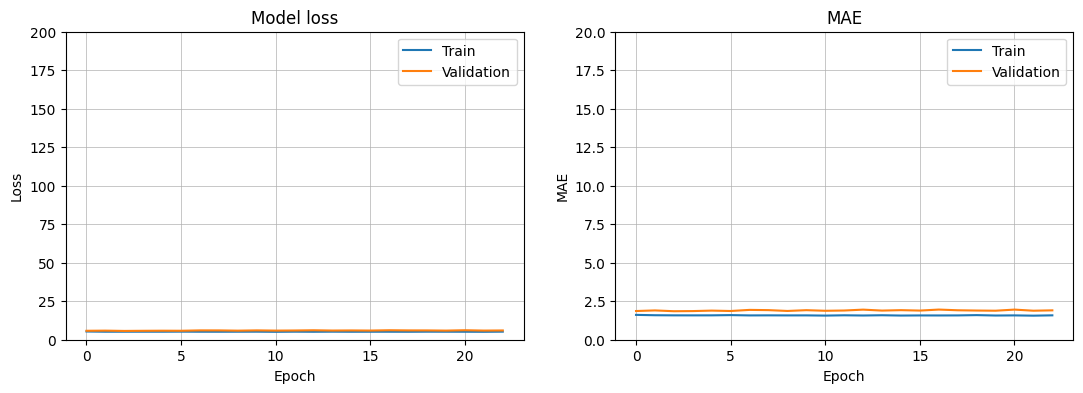

Epoch 1/500
21/21 [==============================] - 0s 3ms/step - loss: 5.2030 - mae: 1.5824 - val_loss: 5.9334 - val_mae: 1.8971
Epoch 2/500
21/21 [==============================] - 0s 746us/step - loss: 5.0985 - mae: 1.5697 - val_loss: 5.9203 - val_mae: 1.8872
Epoch 3/500
21/21 [==============================] - 0s 747us/step - loss: 5.1439 - mae: 1.5700 - val_loss: 5.9192 - val_mae: 1.8781
Epoch 4/500
21/21 [==============================] - 0s 730us/step - loss: 5.2004 - mae: 1.6047 - val_loss: 5.9310 - val_mae: 1.8913
Epoch 5/500
21/21 [==============================] - 0s 683us/step - loss: 5.1637 - mae: 1.5788 - val_loss: 5.8796 - val_mae: 1.8651
Epoch 6/500
21/21 [==============================] - 0s 668us/step - loss: 5.1294 - mae: 1.5736 - val_loss: 5.9380 - val_mae: 1.9045
Epoch 7/500
21/21 [==============================] - 0s 674us/step - loss: 5.1055 - mae: 1.5727 - val_loss: 6.0600 - val_mae: 1.9150
Epoch 8/500
21/21 [==============================] - 0s 677us/step - lo

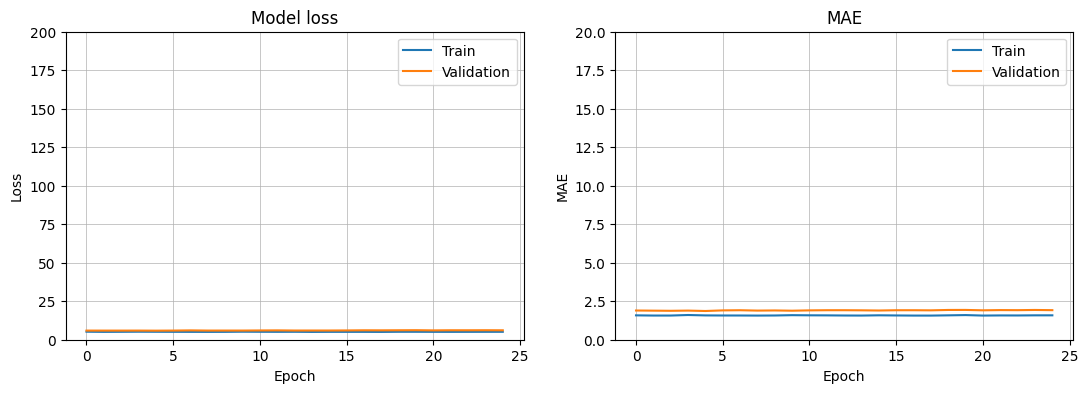

In [109]:
optimizers = ['adagrad','rmsprop', 'adam']

for optimizer in optimizers:
    
    m = compile_model(model, optimizer)

    es = EarlyStopping(patience=20, restore_best_weights=True)

# Fit the model on the train data
    history = m.fit(
        X_train_scaled,
        y_train,
        epochs = 500,
        batch_size = 16,
        verbose = 1,
        callbacks = [es],
        validation_split = 0.2,
        shuffle = True# This will call the Early Stopping Criterion for each epoch
    )
    
    result = m.evaluate(scaler.transform(X_test), y_test)
    plot_loss_mae(history)

#### Neural Network vs. Baseline - Part 2

Are your predictions better than those of the baseline model you evaluated at the beginning of the notebook?

In [110]:
# MAE on the testing set for different optimizers
for optimizer, result in zip(['rmsprop', 'adam', 'adagrad'], results):
    print(f"The MAE on the test set with the {optimizer} optimizer is equal to {result:.2f}")

# MAE on the testing set for the baseline model    
print("-"*5)
print(f"The MAE on the test set with the baseline model is equal to {mae_test_baseline:.2f}")

-----
The MAE on the test set with the baseline model is equal to 6.65


#### 💡Answer

<details>
    <summary>Click me</summary>

You can see that the Neural Network beat the baseline when using either `adam` or `rmsprop` as an optimizer but the result was significantly worse with the `adagrad` optimizer.

**👇 The advice from the Deep Learning community is the following 👇:**

🔥 So far, our best-performing optimizer is `adam`. Maybe a mathematician specialized in numerical methods will find a better solver in the future but for the moment, Adam is your best friend and they have already been helping us achieve remarkable results.
</details>

#### Next Steps for this Challenge

👩‍🎓 Do you remember the **Machine Learning > 04.Under The Hood** unit where we coded our **Gradient Descent** by choosing a specific `learning_rate`? It represents how slow/fast your algorithm learns. In other words, it controls the intensity of the change of the weights at each optimization of the NN, at each backpropagation!

🚀 Well, the **solvers** in Machine Learning and the **optimizers** in Deep Learning are advanced iterative methods relying on **hyperparameters**, and the `learning_rate` is one of them!

🤔 How can I control this `learning_rate`?

✅ Instead of calling an optimizer with a string ("adam", "rmsprop", etc.), which uses a default value for the Learning Rate, we will call 📚 [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) objects 📚 and tailor them to our needs.

🧑🏻‍🏫 Different Learning Rates have different consequences, as shown here: 

<img src="https://wagon-public-datasets.s3-eu-west-1.amazonaws.com/06-DL/02-Optimizer-loss-and-fitting/learning_rate.png" alt="Learning rate" height=300>

### (2.2) The Influence of the Learning Rate

### Selecting an Optimizer with a Custom Learning Rate

📚 [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Instead of initializing the optimizer with a string, let's initialize an optimizer manually.

- Instantiate an Adam optimizer with a Learning Rate of $ \alpha = 0.1$
    - Keep the other parameters at their default values
- Use this optimizer in the `compile_model` function
- Train/fit the model
- Plot the history
- Evaluate your model

4/4 [==============================] - 0s 409us/step - loss: 28.1676 - mae: 3.8001
Mean absolute error with a learning rate of 0.1: 3.8001


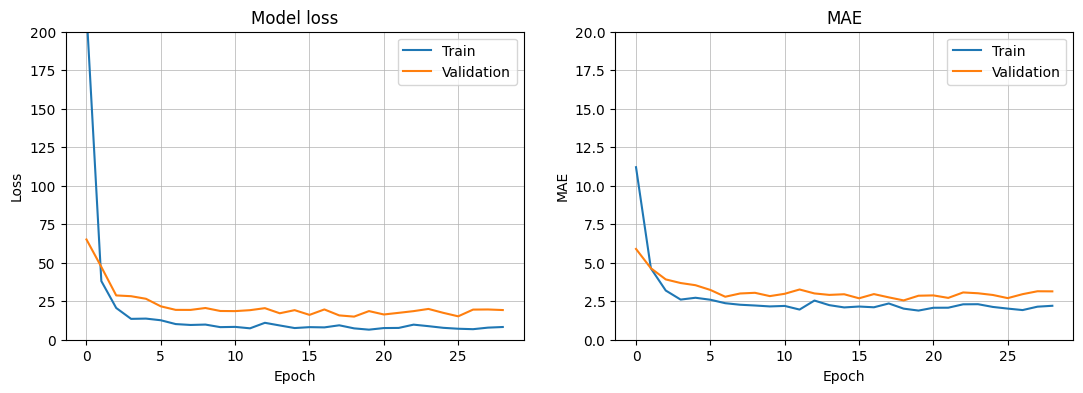

CPU times: user 835 ms, sys: 168 ms, total: 1 s
Wall time: 655 ms


In [111]:
%%time

# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate = 0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Mean absolute error with a learning rate of 0.1: {res:.4f}')
plot_loss_mae(history)

### ❓Playing with Learning Rates

Now, reproduce the same plots and results but for different Learning Rates.

<details>
    <summary>Remark</summary>

There is a chance that the y-axis is too large for you to visualize some results with some Learning Rates. In that case, feel free to re-write the plot function to plot only the epochs $> 10$.

</details>

4/4 [==============================] - 0s 446us/step - loss: 19.3643 - mae: 3.0890
Mean absolute error with a learning rate of 0.0001: 3.0890


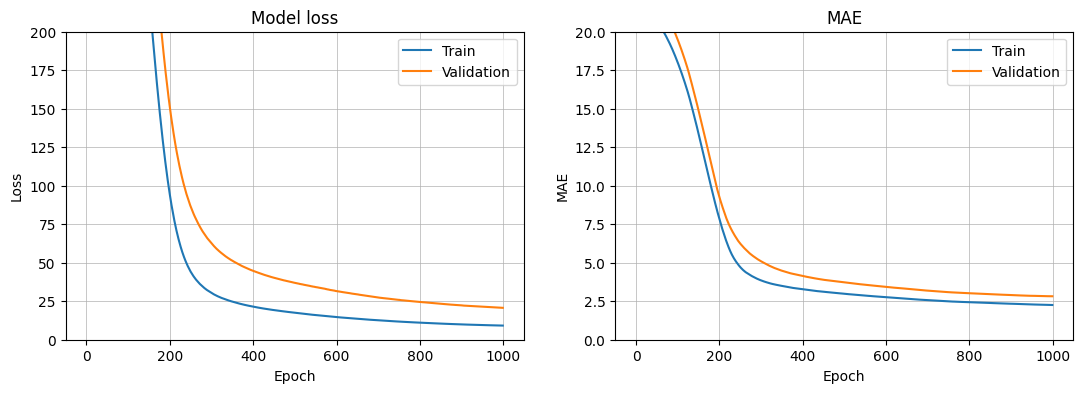

4/4 [==============================] - 0s 481us/step - loss: 18.0130 - mae: 2.9081
Mean absolute error with a learning rate of 0.001: 2.9081


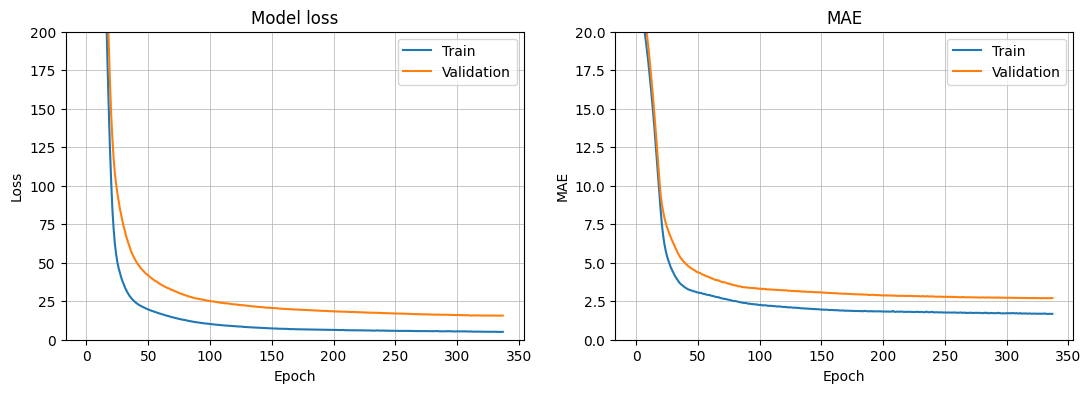

4/4 [==============================] - 0s 438us/step - loss: 19.7437 - mae: 2.8454
Mean absolute error with a learning rate of 0.01: 2.8454


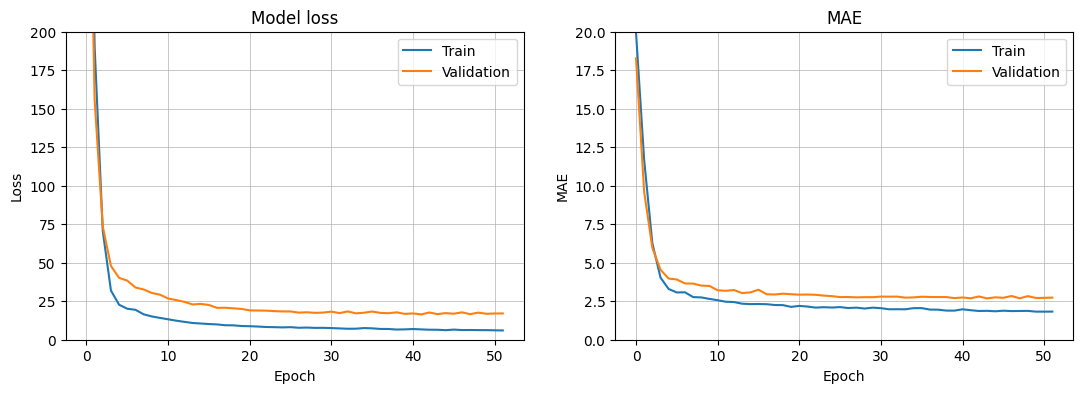

4/4 [==============================] - 0s 436us/step - loss: 23.6482 - mae: 3.2056
Mean absolute error with a learning rate of 0.1: 3.2056


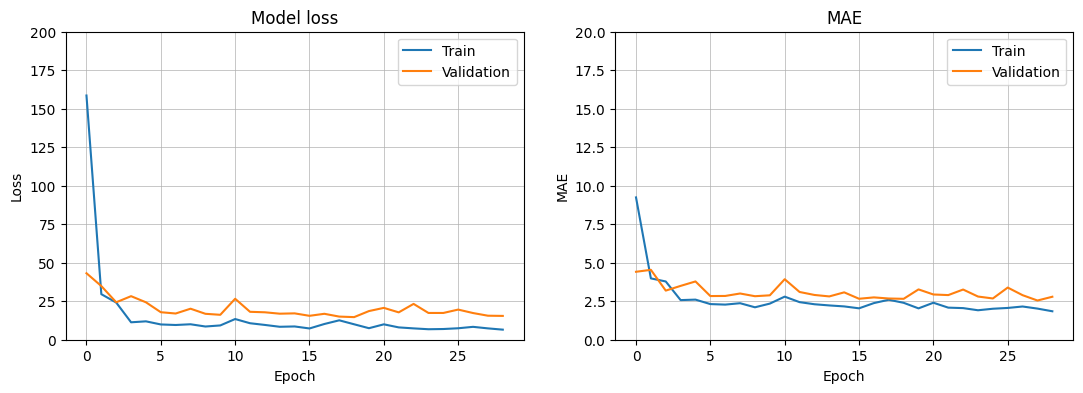

4/4 [==============================] - 0s 425us/step - loss: 84.7000 - mae: 6.5148
Mean absolute error with a learning rate of 1: 6.5148


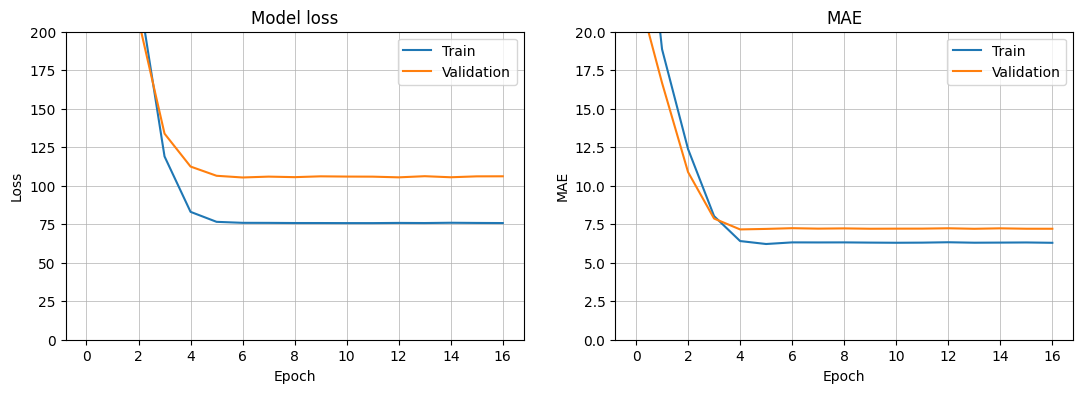

4/4 [==============================] - 0s 445us/step - loss: 84.5661 - mae: 6.5137
Mean absolute error with a learning rate of 2: 6.5137


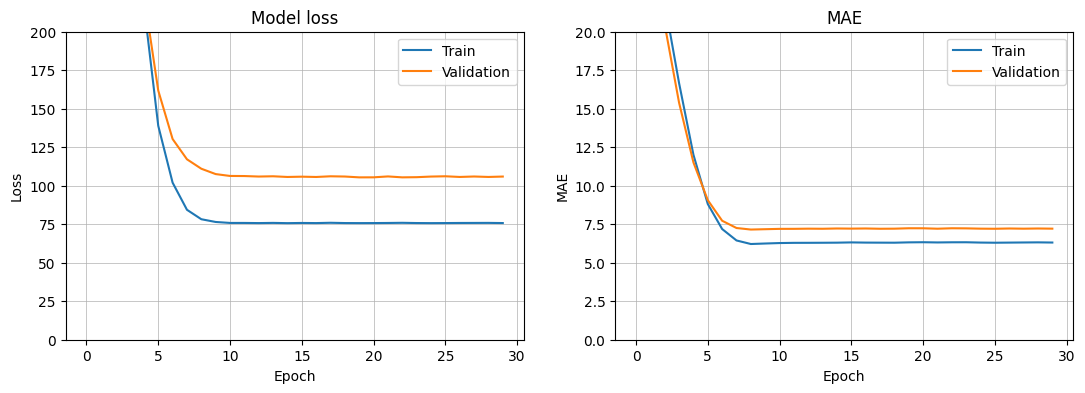

In [117]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []

for learning_rate in learning_rates:
    # 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
    adam = Adam(learning_rate = learning_rate)

# 2. Initializing the model
    model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)

# 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(
        X_train_scaled,
        y_train, 
        validation_split = 0.3,
        shuffle = True,
        batch_size=16, 
        epochs = 1_000,
        callbacks = [es],
        verbose = 0
        )

# 5. Plot the history and evaluate the model
    res = model.evaluate(X_test_scaled, y_test)[1]
    res
    print(f'Mean absolute error with a learning rate of {learning_rate}: {res:.4f}')
    plot_loss_mae(history)

## (3) The Loss

---

❗️It's important to clearly understand the **difference between losses and metrics**❗️

- 🏋🏻‍♀️ The **Loss Functions** are computed **during the training procedure**
    - For regression tasks, the classic Loss Functions are **(Root) Mean Squared Error** ((R)MSE), **Mean Absolute Error** (MAE), and **Mean Squared Logarithmic Error** (MSLE, as seen in the Kaggle challenge)
    - For classification tasks, the classic Loss Functions are **Binary Crossentropy** (also known as LogLoss), **Categorical Crossentropy**, Hinge Loss, etc.
- 🧑🏻‍🏫 The **metrics** are computed to evaluate your models, **after training them**!
    - For regression tasks, common metrics are MSE, MAE, RMSE, Coefficient of Determination (R2), etc.
    - For classification tasks, common metrics are Accuracy, Recall, Precision, and F1-Score
- 👀 Notice that some metrics can also be used as Loss Functions, as long as they are differentiable! (e.g. the **MSE**)

If these notions are not clear, we strongly advise reviewing **Machine Learning > 03.Performance Metrics** and **Machine Learning > 05.Model Tuning**

---

⏩ Alright, after this reminder, let's move on:

### ❓Optimizing a Model with a certain Loss Function

- Run the same NN, once with `mae` as the loss, and once with `mse`
- In both cases, compare `mae_train`, `mae_val`, `mse_train`, `mse_val`

In [120]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate = 0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer

model.compile(loss='mse', # We've already mentioned this loss function in Logistic Regression
              optimizer='adam', # Optimizer in Deep Learning = solver in Machine Learning | Adam = our best friend
              metrics=['mae'])#

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Mean absolute error with a learning rate of 0.001: {res:.4f}')

4/4 [==============================] - 0s 420us/step - loss: 126.7979 - mae: 8.6630
Mean absolute error with a learning rate of 0.001: 8.6630


In [121]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate = 0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer

model.compile(loss='mae', # We've already mentioned this loss function in Logistic Regression
              optimizer='adam', # Optimizer in Deep Learning = solver in Machine Learning | Adam = our best friend
              metrics=['mae'])#

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Mean absolute error with a learning rate of 0.001: {res:.4f}')

4/4 [==============================] - 0s 416us/step - loss: 2.7376 - mae: 2.7376
Mean absolute error with a learning rate of 0.001: 2.7376


### 💡Learnings

🤔 When you work on this regression task, you want to achieve the lowest MAE in the testing set at the end, right? So why wouldn't we use it directly as a Loss Function that would decrease with the number of epochs? 

<details>
    <summary>Answer</summary>

Well, even the Deep Learning research community is still trying to answer these types of questions rigorously.

One thing is sure: in Deep Learning, you will never really reach the "global minimum" of the true Loss Function (the one computed using your entire training set as one single batch). So, in your first model (minimizing the MAE loss), your global MAE minimum has clearly **not** been reached (otherwise you could never beat it). 

Why? It may well be that the minimization process of the second model has performed better. Maybe because the Loss Function "energy map" is "smoother" or more "convex" in the case of MSE loss? Or maybe your hyper-parameters are best suited to the MSE than to the MAE loss?

</details>

## (4)  Saving and Loading a Trained Neural Network

🤯 Imagine that you trained a complex Neural Network (many layers/neurons) on a huge dataset. The parameters of your Deep Learning Model (weights and biases) are now optimized and you would like to share these weights with a teammate who wants to predict a new data point. Would you give this person your notebook for them to run it and then predict the new data point? Hell no, we have a much better solution:
- 💾 Save the weights of the optimized Neural Network
- 🤝 Your friend/colleague/teammate/classmate can use them to predict a new data point

### ❓Training a Good Model

- Try to reach an MAE on the testing set that is lower than 5 (_feel free to re-create the architecture and redefine your compiling parameters in this section!_)
    - Remember: we are predicting house prices, so a mistake of less than 5.000 USD is already good in the real estate industry)

- Whether you managed to reach it or not, move on to the "Saving a Model" section after a few attempts.

In [122]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate = 0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer

model.compile(loss='mae', # We've already mentioned this loss function in Logistic Regression
              optimizer='adam', # Optimizer in Deep Learning = solver in Machine Learning | Adam = our best friend
              metrics=['mae'])#

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Mean absolute error with a learning rate of 0.001: {res:.4f}')



4/4 [==============================] - 0s 440us/step - loss: 2.9422 - mae: 2.9422
Mean absolute error with a learning rate of 0.001: 2.9422


In [123]:
mae_test = 2.7376

In [124]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'solution',
    mae_test = mae_test
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/yleniafedi/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/yleniafedi/code/yleniafedi/06-Deep-Learning/02-Optimizer-loss-and-fitting/data-finetune-your-neural-network/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_solution.py::TestSolution::test_is_score_beat_baseline PASSED       [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/solution.pickle

git commit -m 'Completed solution step'

git push origin master



### ❓Saving a Model

📚 [`tf.keras.models.save_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)

Save your model using the `.save_model(model, 'name_of_my_model')` method.

### ❓Loading a Model

📚 [`tf.keras.models.load_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model)

- Load the model that you've just saved using `.load_model('name_of_your_model')` and store it into a variable called `loaded_model`
- Evaluate it on the testing data to check that it gives the same result as before

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

## (5) (Optional) Exponential Decay

❗️Warning❗️ 

- This section is optional and for advanced practitioners
- The next question is not essential and can be indeed skipped as many algorithms can be run without such optimization

🧑🏻‍🏫 Instead of keeping a fixed Learning Rate, you can change it from one iteration to the other, with the intuition that at first, you need a large Learning Rate to learn fast, and as the Neural Network converges and gets closer to the minimum of the Loss Function, you can decrease the value of the Learning Rate. This is called a **scheduler**. 

### ❓The Exponential Decay Scheduler

Use the 📚 [Exponential Decay Scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) 📚 in the `adam` optimizer, and run it on the previous data.

Start with the following:

```python
initial_learning_rate = 0.001 # start with default Adam value

lr_schedule = ExponentialDecay(
    # Every 5000 iterations, multiply the learning rate by 0.7
    initial_learning_rate, decay_steps = 5000, decay_rate = 0.7,
)
```

In [ ]:
X_train.shape[0] * 0.7 / 16

In [ ]:
# YOUR CODE HERE

## 🏁 Congratulations!

💾 Do not forget to `git add/commit/push` your notebook...

🚀 ... and move to the next challenge!

---

**Further reading after your bootcamp:**

The **Boston Housing Dataset** was deprecated by Scikit-Learn for ethical reasons, and TensorFlow may also replace it in the future.

A certain M. Carlisle wrote a 12-min read article called ["Racist Data Destruction"](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8) to investigate this problem.